# Vehicle Loan Prediction Machine Learning Model

# Chapter 4 - Feature Engineering

### Recap and Load

- As always, let's begin by importing our libraries and loading the data
- Notice that we have a new import from sklearn.preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
loan_df = pd.read_csv('../data/vehicle_loans_eda.csv', index_col='UNIQUEID')

Let’s bring in the explore_categorical and explore_continuous functions we created in chapter 3

In [2]:
#explore categorical
def explore_categorical(col_name):   
    #type solution here
    print("{0} Summary".format(col_name))
    print("\n")

    print("{0} Counts".format(col_name))
    print(loan_df[col_name].value_counts())
    print("\n")

    print("{0} Ratio".format(col_name))
    print(loan_df[col_name].value_counts(normalize=True))
    print("\n")

    print("{0} Default Counts".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts().unstack(level=-1))
    print("\n")

    print("{0} Default Ratio".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts(normalize=True).unstack(level=-1))
    print("\n")

    sns.catplot(data=loan_df,kind='count',x=col_name,hue='LOAN_DEFAULT')
    plt.show()

In [4]:
#explore continuous
def explore_continuous(col_name):
    #type solution here
    print("{0} Summary".format(col_name))
    print("\n")
    print(loan_df[col_name].describe())
    print("\n")

    #Look at boxplot
    sns.boxplot(x=col_name, data=loan_df)
    plt.show()

    #Look at the distribution
    sns.distplot(loan_df[col_name], hist=False)
    plt.show()

    #Now lets look deeper by grouping with the target variable 
    print("{0} Grouped Summary".format(col_name))
    print("\n")
    print(loan_df.groupby('LOAN_DEFAULT')[col_name].describe())

    #look at grouped boxplot 
    sns.boxplot(x=col_name, y='LOAN_DEFAULT', data=loan_df, orient="h")
    plt.show()

## Lesson 1 - Binning

Our first lesson is all about binning, so make sure you have covered the theory lesson that accompanies this chapter

In our exploratory analysis, we observed that disbursed amount had some extremely large values?

Let's take another look at that with our explore_continuous function

DISBURSED_AMOUNT Summary


count    233154.000000
mean      54356.993528
std       12971.314171
min       13320.000000
25%       47145.000000
50%       53803.000000
75%       60413.000000
max      990572.000000
Name: DISBURSED_AMOUNT, dtype: float64




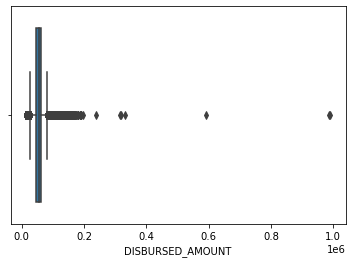

C:\Users\richard.rodrot\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


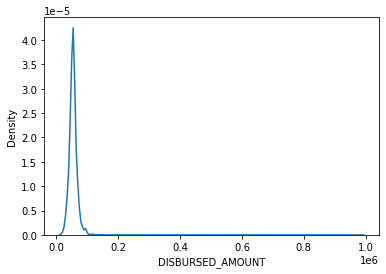

DISBURSED_AMOUNT Grouped Summary


                 count          mean           std      min      25%      50%  \
LOAN_DEFAULT                                                                    
0             182543.0  53826.471111  13140.699007  13320.0  46369.0  53303.0   
1              50611.0  56270.473869  12150.255527  13369.0  49303.0  55459.0   

                  75%       max  
LOAN_DEFAULT                     
0             59947.0  990572.0  
1             61947.0  191392.0  


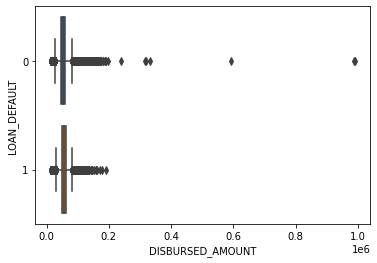

In [5]:
#explore disbursed amount
explore_continuous('DISBURSED_AMOUNT')

Notice that the largest value here is 990,572 this is considerably larger than the next largest value which is also an extreme outlier 

Is it possible that this could be an error in the data?
- If we assume that the disbursal amount is stored in Indian rupees then 990,572 equates to ~ £10,000 or $13,400
- Indeed a lot of money but not impossible for a car loan 

Let's check the row data, LTV and ASSET_COST should give us an idea about whether or not this is a valid piece of data 

Pandas gives us the [idxmax](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.idxmax.html) function to find the index of the row with the maximum value of a column

In [6]:
#get row index of max disbursed amount
loan_df['DISBURSED_AMOUNT'].idxmax()

440173

Now we have the row index but how can we select the row?

Dataframe rows can be selected by their index using the [loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) function

In [7]:
#use idmax to get row
loan_df.loc[loan_df['DISBURSED_AMOUNT'].idxmax()]

DISBURSED_AMOUNT                                                                  990572
ASSET_COST                                                                       1628992
LTV                                                                                61.39
MANUFACTURER_ID                                                                      152
EMPLOYMENT_TYPE                                                                  Missing
STATE_ID                                                                               9
AADHAR_FLAG                                                                            1
PAN_FLAG                                                                               1
VOTERID_FLAG                                                                           0
DRIVING_FLAG                                                                           0
PASSPORT_FLAG                                                                          0
PERFORM_CNS_SCORE    

Ok, it seems reasonable that the applicant borrowed 990,572 to pay for a car that cost 1,628,992. Let's assume a legitimate value that we want to include in our model 

One way we can keep extreme values without them skewing the data is through binning
- Creating categorical groups from continuous variables 

Let's create some bins based on the disbursed amount


In [8]:
#create buckets for disbursed amount
disbursed_buckets = [13000, 30000, 45000, 60000, 75000, 150000, 1000000]
disbursed_labels = ['13k - 30k', '30k - 45k', '45k - 60k', '60k - 75k', '75k - 150k', '150k - 1m']

Great, now we need to use these bins to categorize our rows based on their disbursed amounts

Pandas provides the [cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) which allows us to create buckets and labels

In [9]:
#use cut to assign rows to new buckets
loan_df['DISBURSED_CAT'] = pd.cut(loan_df['DISBURSED_AMOUNT'], disbursed_buckets, labels = disbursed_labels)

Let's use explore_categorical to take a look at our new column!

DISBURSED_CAT Summary


DISBURSED_CAT Counts
45k - 60k     126904
60k - 75k      49824
30k - 45k      40626
75k - 150k     10871
13k - 30k       4865
150k - 1m         64
Name: DISBURSED_CAT, dtype: int64


DISBURSED_CAT Ratio
45k - 60k     0.544293
60k - 75k     0.213696
30k - 45k     0.174245
75k - 150k    0.046626
13k - 30k     0.020866
150k - 1m     0.000274
Name: DISBURSED_CAT, dtype: float64


DISBURSED_CAT Default Counts
LOAN_DEFAULT       0      1
DISBURSED_CAT              
13k - 30k       4207    658
30k - 45k      34323   6303
45k - 60k      98830  28074
60k - 75k      37056  12768
75k - 150k      8070   2801
150k - 1m         57      7


DISBURSED_CAT Default Ratio
LOAN_DEFAULT          0         1
DISBURSED_CAT                    
13k - 30k      0.864748  0.135252
30k - 45k      0.844853  0.155147
45k - 60k      0.778778  0.221222
60k - 75k      0.743738  0.256262
75k - 150k     0.742342  0.257658
150k - 1m      0.890625  0.109375




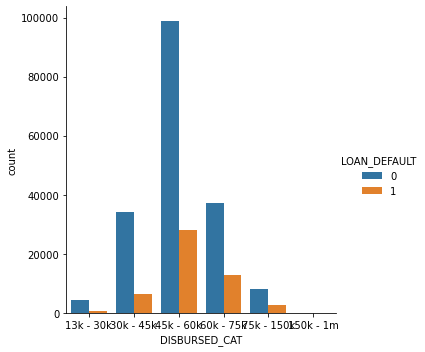

In [10]:
#explore new variable
explore_categorical('DISBURSED_CAT')

Notice that the vast majority of loans fall in the '45k - 60k' bucket. 

Also, the higher the loan amount, the more likely it was to default except for loans in the very largest category

## Lesson 2 - Combine Features

### Disbursal Difference

One brilliant feature of pandas, is that it allows us to easily create new columns by combining existing ones 

We can use mathematical operations to create new features from existing ones with just one line of code! 

- HINT: We already did this to create our AGE column in chapter 2

Let's revisit this idea by creating a DISBURSAL_DIFFERENCE column which will be the difference between the ASSET_COST and the DISBURSED_AMOUNT

In [11]:
#calculate disbursal difference
loan_df['DISBURSAL_DIFFERENCE'] = loan_df['ASSET_COST'] - loan_df['DISBURSED_AMOUNT']

Let's inspect our new column

In [12]:
#inspect new column
loan_df[['DISBURSAL_DIFFERENCE', 'ASSET_COST', 'DISBURSED_AMOUNT']].sample(10)

,DISBURSAL_DIFFERENCE,ASSET_COST,DISBURSED_AMOUNT
UNIQUEID,,,
544646,20650,69499,48849
579230,14728,71787,57059
569343,30810,83113,52303
429953,11192,65741,54549
632884,26290,68500,42210
484973,15011,66514,51503
532448,17575,62320,44745
499231,18367,84236,65869
486188,14583,88000,73417


### Primary and Secondary Account Engineering

The loan data contains 14 columns providing information about any existing loans a customer may have. This data is split according to primary and secondary accounts, a primary account is a loan where the customer is the sole recipient of the disbursal, 
a secondary account is one where the customer is a co-applicant or guarantor for the loan 

- PRI_NO_OF_ACCTS: count of total loans taken by the customer at the time of disbursement  
- PRI_ACTIVE_ACCTS: count of active loans taken by the customer at the time of disbursement
- PRI_OVERDUE_ACCTS: count of default accounts at the time of disbursement    
- PRI_CURRENT_BALANCE: total Principal outstanding amount of the active loans at the time of disbursement        
- PRI_SANCTIONED_AMOUNT: total amount that was sanctioned for all the loans at the time of disbursement  
- PRI_DISBURSED_AMOUNT: total amount that was disbursed for all the loans at the time of disbursement
- PRIMARY_INSTAL_AMT: EMI Amount of the primary loan
- SEC_NO_OF_ACCTS: count of secondary total loans taken by the customer at the time of disbursement 
- SEC_ACTIVE_ACCTS: count of secondary active loans taken by the customer at the time of disbursement 
- SEC_OVERDUE_ACCTS: count of secondary accounts at the time of disbursement    
- SEC_CURRENT_BALANCE: total Principal outstanding amount of the secondary active loans at the time of disbursement 
- SEC_SANCTIONED_AMOUNT: total amount that was sanctioned for all the secondary loans at the time of disbursement  
- SEC_DISBURSED_AMOUNT: total amount that was disbursed for all the secondary loans at the time of disbursement
- SEC_INSTAL_AMT: EMI Amount of the secondary loan 

If you haven’t done so already please take a few minutes to explore these primary and secondary account variables using the explore_continuous function

Hopefully, you will see that in the majority of cases the data in these columns is limited

Instead of simply dropping them, we will combine so we can reduce the complexity of our data without losing information

For example, we can create a column 'TOTAL_ACCTS' to store the combined total of primary and secondary accounts


In [13]:
#create new total accounts column
loan_df['TOTAL_ACCTS'] = loan_df['PRI_NO_OF_ACCTS'] + loan_df['SEC_NO_OF_ACCTS']

Let's look at the results of this just to sanity check

In [14]:
#inspect new column
loan_df[['TOTAL_ACCTS', 'PRI_NO_OF_ACCTS', 'SEC_NO_OF_ACCTS']].sample(10)

,TOTAL_ACCTS,PRI_NO_OF_ACCTS,SEC_NO_OF_ACCTS
UNIQUEID,,,
491148,0,0,0
550935,0,0,0
542382,0,0,0
426570,0,0,0
436802,0,0,0
643385,0,0,0
560369,14,14,0
555987,9,9,0
556244,6,6,0


### EXERCISE

- Use this example to create TOTAL_ columns from the remaining primary/secondary variables
- HINT: After this, you should have 7 new columns including 'TOTAL_ACCTS'

### SOLUTION

In [15]:
# type solution here
loan_df['TOTAL_ACTIVE_ACCTS'] = loan_df['PRI_ACTIVE_ACCTS'] + loan_df['SEC_ACTIVE_ACCTS']
loan_df['TOTAL_OVERDUE_ACCTS'] = loan_df['PRI_OVERDUE_ACCTS'] + loan_df['SEC_OVERDUE_ACCTS']
loan_df['TOTAL_CURRENT_BALANCE'] = loan_df['PRI_CURRENT_BALANCE'] + loan_df['SEC_CURRENT_BALANCE']
loan_df['TOTAL_SANCTIONED_AMOUNT'] = loan_df['PRI_SANCTIONED_AMOUNT'] + loan_df['SEC_SANCTIONED_AMOUNT']
loan_df['TOTAL_DISBURSED_AMOUNT'] = loan_df['PRI_DISBURSED_AMOUNT'] + loan_df['SEC_DISBURSED_AMOUNT']
loan_df['TOTAL_INSTAL_AMT'] = loan_df['PRIMARY_INSTAL_AMT'] + loan_df['SEC_INSTAL_AMT']

Brilliant! Now we have simplified our dataset by combining the primary and secondary account columns 

Let's drop the ones we no longer need to avoid data duplication

In [16]:
# drop primary and secondary columns
drop_cols = ['PRI_NO_OF_ACCTS',
            'PRI_ACTIVE_ACCTS',
             'PRI_OVERDUE_ACCTS',
             'PRI_CURRENT_BALANCE',
             'PRI_SANCTIONED_AMOUNT',
             'PRI_DISBURSED_AMOUNT',
             'PRIMARY_INSTAL_AMT',
             'SEC_NO_OF_ACCTS',
             'SEC_ACTIVE_ACCTS',
             'SEC_OVERDUE_ACCTS',
             'SEC_SANCTIONED_AMOUNT',
             'SEC_DISBURSED_AMOUNT',
             'SEC_INSTAL_AMT',
             'SEC_CURRENT_BALANCE'
            ]
loan_df = loan_df.drop(drop_cols, axis=1)

We may also be interested in calculating the percentage of overdue accounts a person has

### EXERCISE

- Create a column 'OVERDUE_PCT' that stores the percentage of overdue accounts

### SOLUTION

In [17]:
#type solution here
loan_df['OVERDUE_PCT'] = loan_df['TOTAL_OVERDUE_ACCTS'] / loan_df['TOTAL_ACCTS']

Wait! We better check this new column for missing values, remember a lot of rows will have 0 'TOTAL_ACCTS'

We can investigate using [isnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isnull.html) and [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html)

In [18]:
#check for missing values
loan_df['OVERDUE_PCT'].isnull().sum()


115792

Ok, we have a lot of missing values we can fill them with 0s using [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.fillna.html)

In [19]:
#fill missing values
loan_df['OVERDUE_PCT'] = loan_df['OVERDUE_PCT'].fillna(0)

Let's use [isnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isnull.html) and [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html) again to make sure we no longer have missing values

In [20]:
#double check missing values
loan_df['OVERDUE_PCT'].isnull().sum()

0

Brilliant, our new OVERDUE_PCT column no longer has any missing values. 

We have done a lot of feature engineering so far, so let's use the [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) function to take a look at our columns

In [21]:
#take a look at remaining columns
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 420825 to 630213
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   DISBURSED_AMOUNT                     233154 non-null  int64   
 1   ASSET_COST                           233154 non-null  int64   
 2   LTV                                  233154 non-null  float64 
 3   MANUFACTURER_ID                      233154 non-null  int64   
 4   EMPLOYMENT_TYPE                      233154 non-null  object  
 5   STATE_ID                             233154 non-null  int64   
 6   AADHAR_FLAG                          233154 non-null  int64   
 7   PAN_FLAG                             233154 non-null  int64   
 8   VOTERID_FLAG                         233154 non-null  int64   
 9   DRIVING_FLAG                         233154 non-null  int64   
 10  PASSPORT_FLAG                        233154 non-null  int64   


Nice! We have reduced our number of columns to 31

Also, notice the presence of our new columns at the bottom of the list.

## Lesson 3 - Scaling 

- We will use min max scaling to bring our continuous variables into the same range 
- Outliers have been observed in the data. However, we will keep them as they appear to be legitimate
- Sklearn provides an implementation of Min Max scaling, [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

First, we create a list of our continuous columns 
- We can use this list to select the continuous variables from our dataframe without typing a long list of column names each time 
- We don't need to scale our categoricals or binaries



In [28]:
#create list of numeric columns
numeric_cols = ['DISBURSED_AMOUNT', 
                'ASSET_COST', 
                'LTV', 
                'NEW_ACCTS_IN_LAST_SIX_MONTHS', 
                'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 
                'NO_OF_INQUIRIES', 
                'AGE', 
                'AVERAGE_ACCT_AGE_MONTH', 
                'CREDIT_HISTORY_LENGTH_MONTHS',
                'PERFORM_CNS_SCORE',
                'TOTAL_ACCTS',
                'TOTAL_ACTIVE_ACCTS',
                'TOTAL_OVERDUE_ACCTS',
                'TOTAL_CURRENT_BALANCE', 
                'TOTAL_SANCTIONED_AMOUNT', 
                'TOTAL_DISBURSED_AMOUNT', 
                'TOTAL_INSTAL_AMT', 
                'OVERDUE_PCT', 
                'DISBURSAL_DIFFERENCE']

Let's look at the numeric columns so we have a reference. 

We can plot multiple columns on the same plot using pandas [boxplot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html)

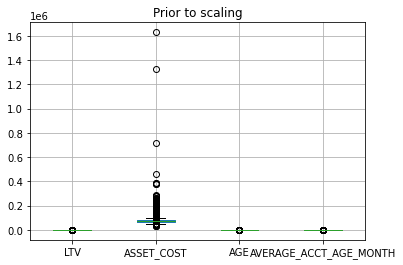

In [29]:
#visualize the problem
loan_df[['LTV', 'ASSET_COST', 'AGE', 'AVERAGE_ACCT_AGE_MONTH']].boxplot()
plt.title('Prior to scaling')
plt.show()

Observe that the numeric values are distributed across very different scales.

Let's fix this problem using Min Max Scaling. 

First we need to create an instance of [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 

In [30]:
#create instance of min max scaler
mm_scaler = MinMaxScaler()

We can use [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.fit_transform) to fit the scaler to our data and perform the scaling

In [31]:
#apply fit transform
loan_df[numeric_cols] = mm_scaler.fit_transform(loan_df[numeric_cols])


Let's have a quick look at the boxplots now

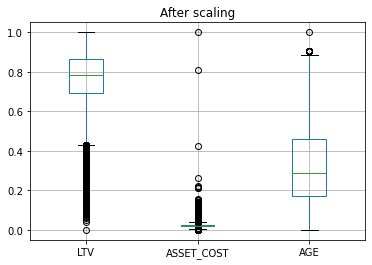

In [32]:
#visualize transformed column
loan_df[['LTV', 'ASSET_COST', 'AGE']].boxplot()
plt.title('After scaling')
plt.show()

Now all the values are ranged between 1 and 0

Take some time now to look at some of our other numeric columns after we have scaled them

## Conclusion

- In this chapter, we have performed some basic feature engineering 
- We have created a new categorical column using binning on 'DISBURSED_AMOUNT'
- We have combined features to create new ones 
- We have performed MinMax scaling on our numeric variables

Let's save our data to file!

In [33]:
#save our data
loan_df.to_csv('../data/vehicle_loans_feat.csv')